In [17]:
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
matplotlib.rcParams['figure.dpi'] = 80 #300

import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid", {'grid.linestyle': '--'})

Loading the players dataframe exported in the last part of Task 1...

In [18]:
players = pd.read_pickle('../TASK1/dataset/final_players.pkl')

---

# Clustering Analysis: Hierarchical (part I)

First, let us take a look at the distribution of the number of matches, for each player, from which the features have been extracted

count    2471.000000
mean       62.845002
std        84.748228
min         1.000000
25%         6.000000
50%        20.000000
75%        87.000000
max       367.000000
Name: stats_match_count, dtype: float64

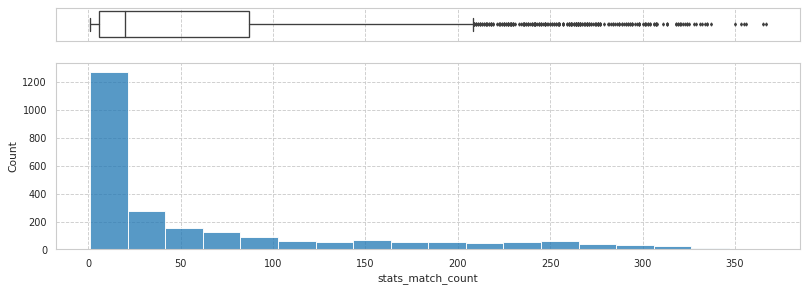

In [19]:
display(players.stats_match_count.describe())

def sturgesBins(n):
    return math.ceil(math.log(n) + 1)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 4))
 
sns.boxplot(data=players, x="stats_match_count", fliersize=2, boxprops={'facecolor':'None'}, ax=ax_box)
sns.histplot(data=players, x="stats_match_count", bins=sturgesBins(len(players))*2, ax=ax_hist)

ax_box.set(xlabel='')
pass

Since $50\%$ of the players count less than 20 matches, we may want to just consider the other half having a greater amount of matches, in order to be sure to work with just the players having more accurate and representative features

In [20]:
players = players[players.stats_match_count >= 20]

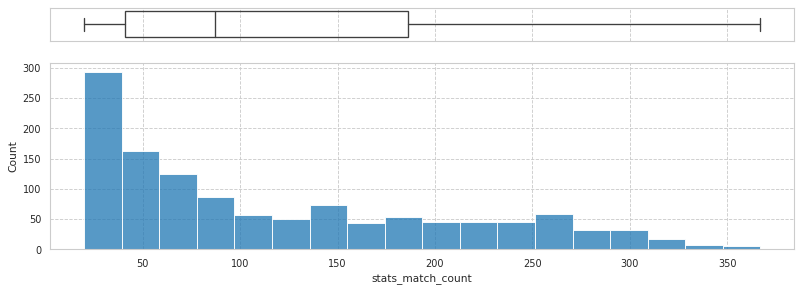

In [21]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 4))
 
sns.boxplot(data=players, x="stats_match_count", fliersize=2, boxprops={'facecolor':'None'}, ax=ax_box)
sns.histplot(data=players, x="stats_match_count", bins=sturgesBins(len(players))*2, ax=ax_hist)

ax_box.set(xlabel='')
pass

We may want to have a total mean rank of each player instead of the mean rank of each semester:

In [22]:
rank_cols = list(filter(lambda s : 'rank_sem' in s, players.columns))
players['mean_rank'] = players[rank_cols].sum(axis=1) / players[rank_cols].notna().sum(axis=1)

Let's see if the players we're going to cluster have a nice distribution of rank:

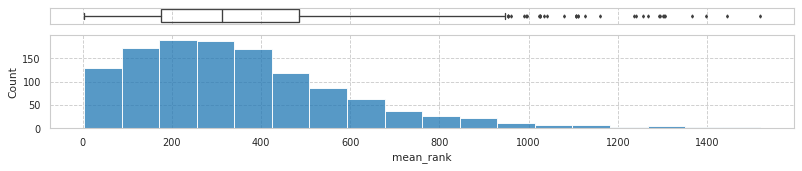

In [23]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 2))
 
sns.boxplot(data=players, x="mean_rank", fliersize=2, boxprops={'facecolor':'None'}, ax=ax_box)
sns.histplot(data=players, x="mean_rank", bins=sturgesBins(len(players))*2, ax=ax_hist)

ax_box.set(xlabel='')
pass

OK: it seems like we have a nice range of rankings

Our aim for this hierarchical clustering, is to find out which set of features makes cluster of players particularly stand out from each other (in other words, which features make for good and sharp distinction between different groups of players).

In order to do this, we will concentrate on most of the ratios and on the mean rank of each player:

In [24]:
FEATURE_COLS = ['ace_ratio', 'df_ratio', 'bp_saved_ratio', 'bp_w_ratio', 'svpt_w_ratio', 'svpt_2nd_w_ratio', 'svpt_1st_fail_ratio', 'w_ratio', 'hard_w_ratio', 'clay_w_ratio', 'mean_rank']

On your marks! Let's prepare the data for the clustering algorithm. We're going to apply a `StandardScaler` to standardize all of our features:

In [25]:
clustering_data = {
    'scaler': StandardScaler(),
    'original': players[FEATURE_COLS].dropna()
}
clustering_data['scaled'] = clustering_data['scaler'].fit_transform(clustering_data['original'])

data_dist = pdist(clustering_data['scaled'], metric='euclidean')

Get set! From now on, each section will apply the agglomerative hierarchical clustering with different methods for calculating the distances between the formed clusters:
- Ward method
- Complete (max) method
- Average method
- Single (min) method

Go!

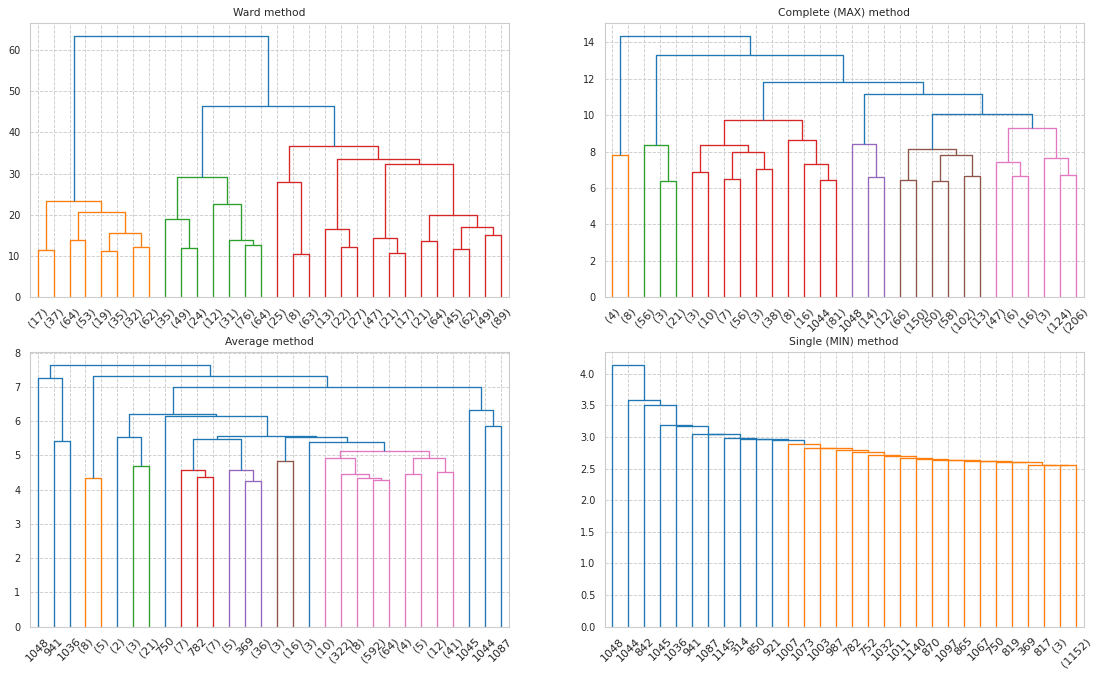

In [26]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
plt.title('Ward method')
_ = dendrogram(linkage(data_dist, method='ward', metric='euclidean'), truncate_mode='lastp')

plt.subplot(2, 2, 2)
plt.title('Complete (MAX) method')
_ = dendrogram(linkage(data_dist, method='complete', metric='euclidean'), truncate_mode='lastp')

plt.subplot(2, 2, 3)
plt.title('Average method')
_ = dendrogram(linkage(data_dist, method='average', metric='euclidean'), truncate_mode='lastp')

plt.subplot(2, 2, 4)
plt.title('Single (MIN) method')
_ = dendrogram(linkage(data_dist, method='single', metric='euclidean'), truncate_mode='lastp')


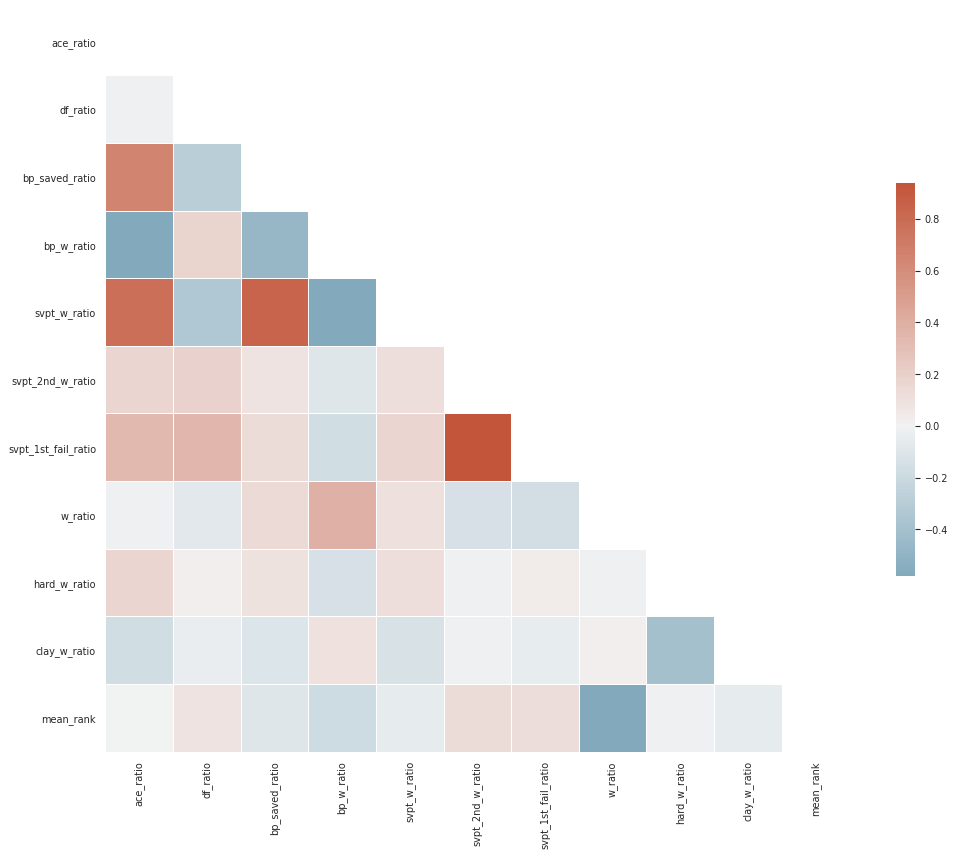

In [34]:
corr = players[FEATURE_COLS].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

---
## Ward method

Let's compute the dendrogram for the Ward method

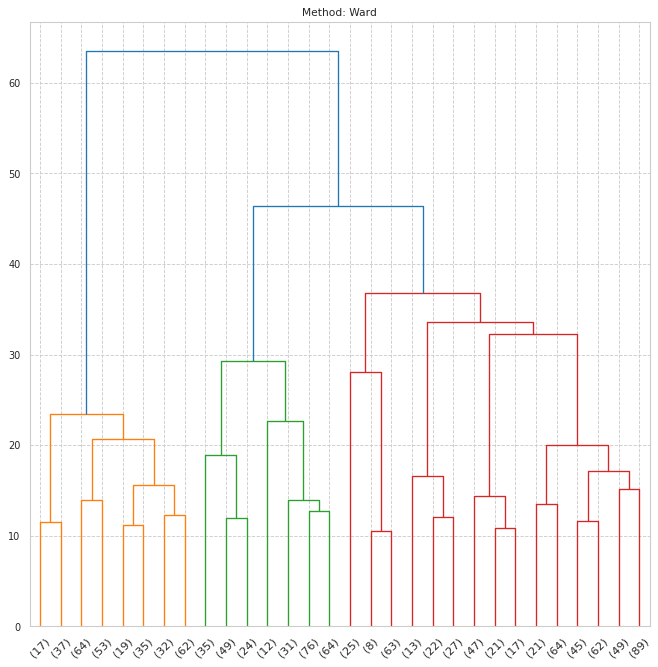

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Method: Ward')
linkage_ward = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(linkage_ward, truncate_mode='lastp')

The suggested number of clusters seems to be 2. We're also going to inspect the clustering that ends with 4 clusters

### 2 clusters

The dendrogram obtained by using the Ward method seems to suggest a clustering with just 2 clusters: let's analyze them

In [28]:
clustering_labels_ward = fcluster(linkage_ward, 2, criterion='maxclust')

clustered_players = clustering_data['original'].copy()
clustered_players['cluster'] = clustering_labels_ward
display(clustered_players['cluster'].value_counts().sort_index())

1    319
2    864
Name: cluster, dtype: int64

It's interesting to note that most male players belong to the cluster 1

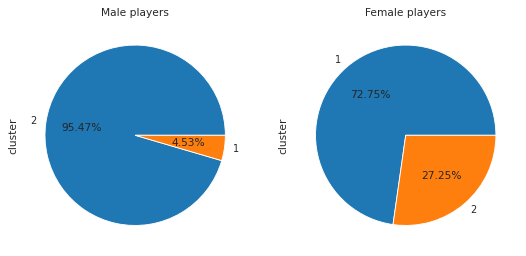

In [33]:
def autopct(pct):
    return str('%.2f' % pct) + '%'

clustered_players_sex = clustered_players.copy().join(players[['sex']])
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Male players')
clustered_players_sex[clustered_players_sex.sex == 'm'].cluster.value_counts().plot(kind='pie', autopct=autopct)
plt.subplot(1, 2, 2)
plt.title('Female players')
clustered_players_sex[clustered_players_sex.sex == 'f'].cluster.value_counts().plot(kind='pie', autopct=autopct)
pass

Let's see which features appear to be the most correlated to the found clusters

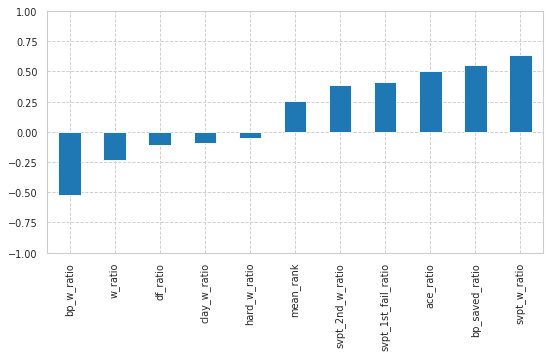

In [41]:
clustered_players.corr()['cluster'].sort_values().drop('cluster').plot(
    kind='bar',
    ylim=(-1, 1),
    figsize=(8, 4)
)
pass

The most correlated features are:
1. `svpt_w_ratio`
2. `bp_w_ratio`
3. `bp_saved_ratio`
4. `ace_ratio`

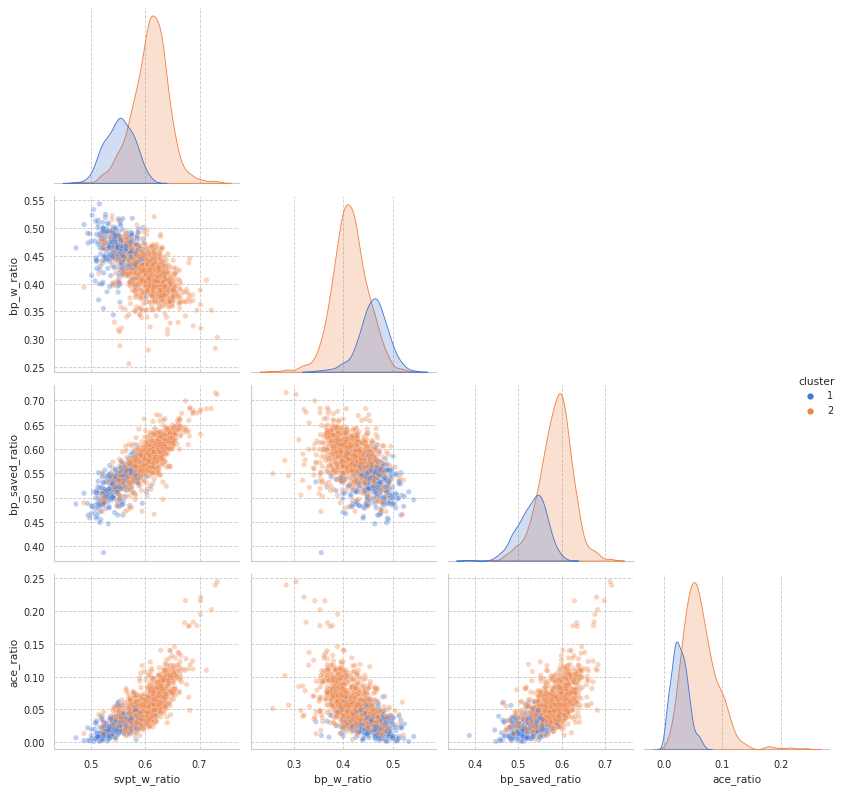

In [42]:
feature_subset = ['svpt_w_ratio', 'bp_w_ratio', 'bp_saved_ratio', 'ace_ratio']

tmp = clustered_players[feature_subset + ['cluster']].copy().reset_index()
tmp.cluster = tmp.cluster.astype(int)
tmp[feature_subset] = tmp[feature_subset].astype(float)
sns.pairplot(data=tmp, hue='cluster', palette='muted', corner=True, plot_kws={'alpha': 0.35})
plt.tight_layout()
plt.show()
pass

### 3 clusters

Prior to obtaining the 2 clusters previously seen, the agglomerative algorithm had the previous cluster 2 (the bigger one) splitted in other 2 clusters, for a total of 3:

In [ ]:
clustering_labels_ward = fcluster(linkage_ward, 3, criterion='maxclust')

clustered_players = clustering_data['original'].copy()
clustered_players['cluster'] = clustering_labels_ward
display(clustered_players['cluster'].value_counts().sort_index())

1    319
2    291
3    573
Name: cluster, dtype: int64

Let's see which features appear to be the most correlated between the two clusters that are then joined

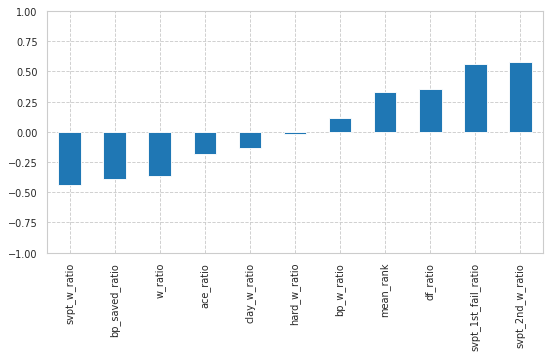

In [44]:
clustered_players[clustered_players.cluster.isin([2, 3])].corr()['cluster'].sort_values().drop('cluster').plot(
    kind='bar',
    ylim=(-1, 1),
    figsize=(8, 4)
)
pass

The most correlated features are:
1. `svpt_2nd_w_ratio`
2. `svpt_1st_fail_ratio`
3. `svpt_w_ratio`
4. `w_ratio`

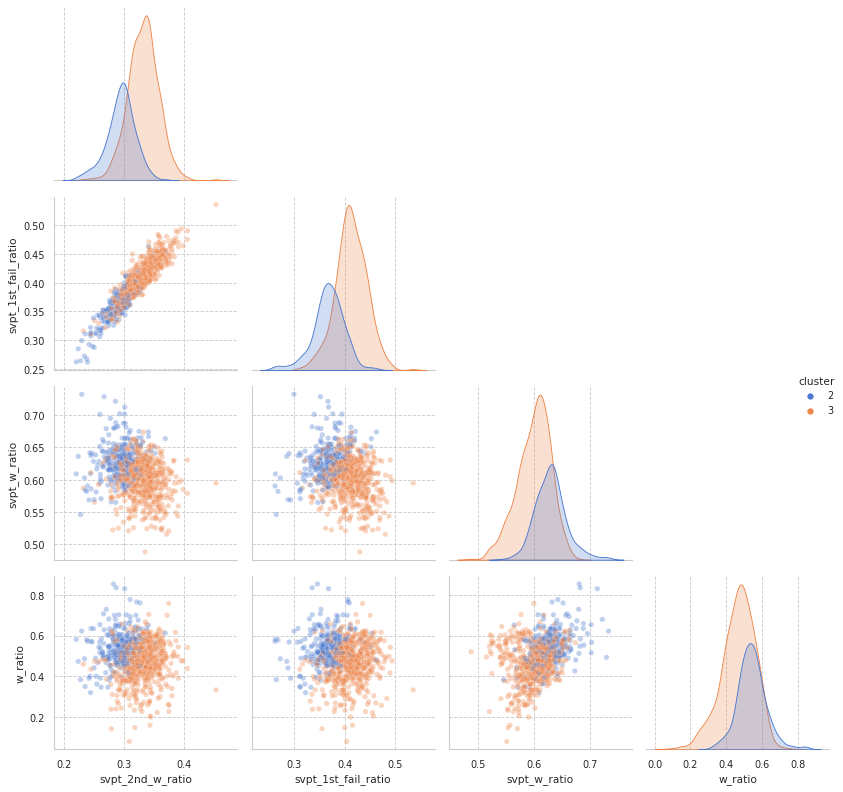

In [48]:
feature_subset = ['svpt_2nd_w_ratio', 'svpt_1st_fail_ratio', 'svpt_w_ratio', 'w_ratio']

tmp = clustered_players.loc[clustered_players.cluster.isin([2, 3]), feature_subset + ['cluster']].copy().reset_index()
tmp.cluster = tmp.cluster.astype(int)
tmp[feature_subset] = tmp[feature_subset].astype(float)
sns.pairplot(data=tmp, hue='cluster', palette='muted', corner=True, plot_kws={'alpha': 0.35})
plt.tight_layout()
plt.show()
pass

---
## Complete (max) method

Let's compute the dendrogram for the Complete method

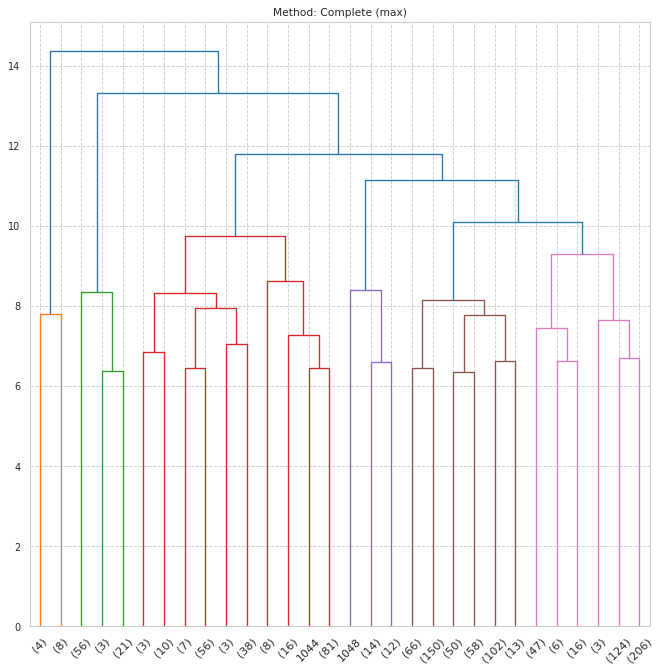

In [49]:
plt.figure(figsize=(10, 10))
plt.title('Method: Complete (max)')
linkage_max = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(linkage_max, truncate_mode='lastp')

This time, the suggested number of clusters seems to be 3

### 2 clusters

One of the 2 final clusters that the algorithm obtains is made of just 12 players

In [50]:
clustering_labels_max = fcluster(linkage_max, 2, criterion='maxclust')

clustered_players = clustering_data['original'].copy()
clustered_players['cluster'] = clustering_labels_max
display(clustered_players['cluster'].value_counts().sort_index())

1      12
2    1171
Name: cluster, dtype: int64

Who are they?

In [57]:
clustered_players[clustered_players.cluster == 1]

,ace_ratio,df_ratio,bp_saved_ratio,bp_w_ratio,svpt_w_ratio,svpt_2nd_w_ratio,svpt_1st_fail_ratio,w_ratio,hard_w_ratio,clay_w_ratio,mean_rank,cluster
fullname,,,,,,,,,,,,
milos raonic,0.201646,0.046936,0.682956,0.352538,0.721722,0.285483,0.366478,0.678862,-0.020179,0.005349,18.416667,1
nick kyrgios,0.194645,0.041823,0.677146,0.38817,0.701434,0.259862,0.339369,0.653465,0.026535,-0.076542,32.166667,1
kevin anderson,0.177438,0.036371,0.673766,0.352524,0.695237,0.277129,0.363707,0.609865,0.002811,-0.051726,55.230769,1
ivo karlovic,0.238947,0.054239,0.715395,0.283784,0.729034,0.266646,0.351698,0.492683,0.011076,-0.080918,91.923077,1
sam querrey,0.177306,0.04399,0.626432,0.377877,0.681474,0.302951,0.411885,0.547414,-0.027144,-0.092868,43.916667,1
reilly opelka,0.220788,0.040168,0.680921,0.320038,0.702371,0.292681,0.376082,0.566265,0.026955,-0.020811,184.166667,1
john isner,0.244322,0.025965,0.711939,0.303787,0.732669,0.229515,0.299249,0.621723,-0.011466,-0.017072,18.153846,1
gilles muller,0.182712,0.04942,0.675141,0.324111,0.688513,0.286082,0.388008,0.553191,-0.029936,-0.178191,47.000000,1
sam groth,0.181883,0.076251,0.63482,0.367681,0.672639,0.308118,0.412355,0.425743,-0.076536,-0.092409,156.600000,1


What makes them stand out from all the other players?

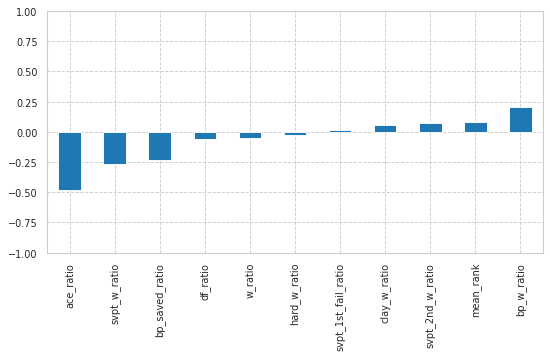

In [54]:
clustered_players.corr()['cluster'].sort_values().drop('cluster').plot(
    kind='bar',
    ylim=(-1, 1),
    figsize=(8, 4)
)
pass

Seems like these 12 male players have an outstanding `ace_ratio`!

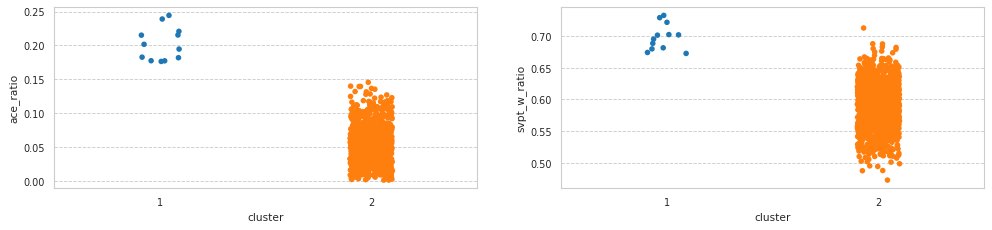

In [56]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
sns.stripplot(x=clustered_players.cluster, y=clustered_players.ace_ratio)
plt.subplot(1, 2, 2)
sns.stripplot(x=clustered_players.cluster, y=clustered_players.svpt_w_ratio)
pass

### 3 clusters

What about 3 clusters? The previous big cluster was actually made of two clusters, being formed by 80 and 1091 players

In [58]:
clustering_labels_max = fcluster(linkage_max, 3, criterion='maxclust')

clustered_players = clustering_data['original'].copy()
clustered_players['cluster'] = clustering_labels_max
display(clustered_players['cluster'].value_counts().sort_index())

1      12
2      80
3    1091
Name: cluster, dtype: int64

Let's examine these new 2 clusters (label 2 and 3)

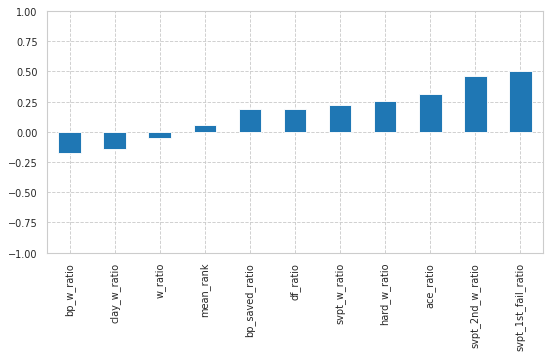

In [63]:
clustered_players[clustered_players.cluster.isin([2, 3])].corr()['cluster'].sort_values().drop('cluster').plot(
    kind='bar',
    ylim=(-1, 1),
    figsize=(8, 4)
)
pass

The most correlated features are:
1. `svpt_1st_fail_ratio`
2. `svpt_2nd_w_ratio`
3. `ace_ratio`

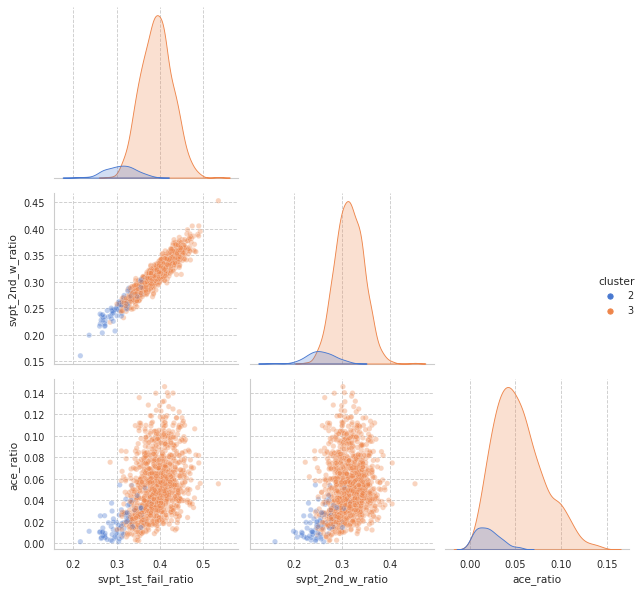

In [64]:
feature_subset = ['svpt_1st_fail_ratio', 'svpt_2nd_w_ratio', 'ace_ratio']

tmp = clustered_players.loc[clustered_players.cluster.isin([2, 3]), feature_subset + ['cluster']].copy().reset_index()
tmp.cluster = tmp.cluster.astype(int)
tmp[feature_subset] = tmp[feature_subset].astype(float)
sns.pairplot(data=tmp, hue='cluster', palette='muted', corner=True, plot_kws={'alpha': 0.35})
plt.tight_layout()
plt.show()
pass

### 4 clusters

And finally, what about 4 clusters?

In [65]:
clustering_labels_max = fcluster(linkage_max, 4, criterion='maxclust')

clustered_players = clustering_data['original'].copy()
clustered_players['cluster'] = clustering_labels_max
display(clustered_players['cluster'].value_counts().sort_index())

1     12
2     80
3    223
4    868
Name: cluster, dtype: int64

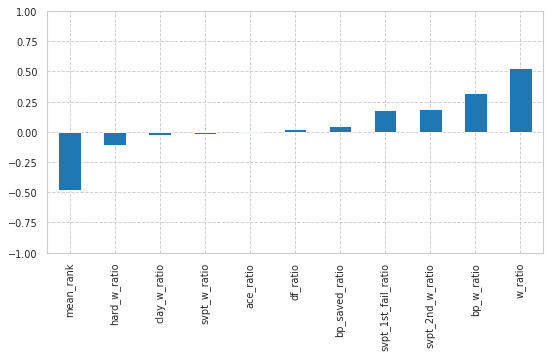

In [66]:
clustered_players[clustered_players.cluster.isin([3, 4])].corr()['cluster'].sort_values().drop('cluster').plot(
    kind='bar',
    ylim=(-1, 1),
    figsize=(8, 4)
)
pass

This time, the algorithm splitted the players according to their ranking (and thus winning ratio)

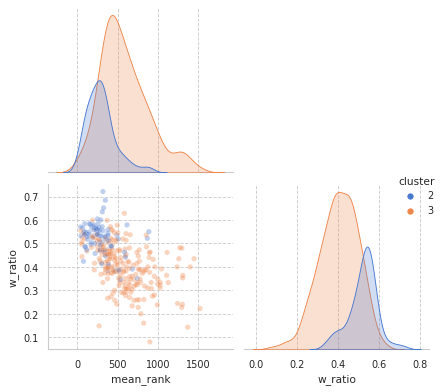

In [72]:
feature_subset = ['mean_rank', 'w_ratio']

tmp = clustered_players.loc[clustered_players.cluster.isin([2, 3]), feature_subset + ['cluster']].copy().reset_index()
tmp.cluster = tmp.cluster.astype(int)
tmp[feature_subset] = tmp[feature_subset].astype(float)
sns.pairplot(data=tmp, hue='cluster', palette='muted', corner=True, plot_kws={'alpha': 0.35})
plt.tight_layout()
plt.show()
pass

---
## Average method

Let's compute the dendrogram for the Average method

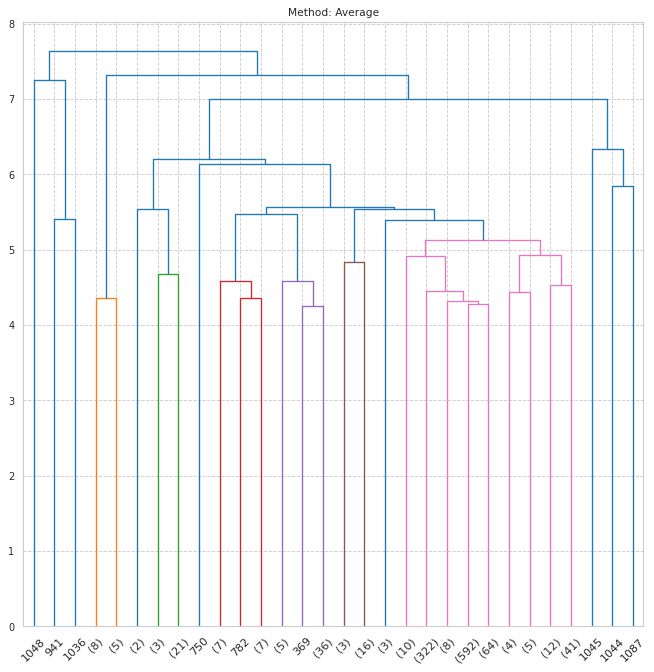

In [73]:
plt.figure(figsize=(10, 10))
plt.title('Method: Average')
linkage_avg = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(linkage_avg, truncate_mode='lastp')

The suggested number of clusters seems to be 5 (the largest one so far!). However:
- 1 of them is made out of just a single player
- 1 of them is made out of just 2 players
- 1 of them is made out of just 3 players
- 1 of them is made out of (8)+(5) players

Let's immediatly see who these players are, and why they belong to different clusters than the main one

### 5 clusters

In [98]:
clustering_labels_avg = fcluster(linkage_avg, 5, criterion='maxclust')

clustered_players = clustering_data['original'].copy()
clustered_players['cluster'] = clustering_labels_avg
display(clustered_players['cluster'].value_counts().sort_index())

1       2
2       1
3      13
4    1164
5       3
Name: cluster, dtype: int64

First, let's see how the 13 players of cluster 3 are

In [88]:
clustered_players[clustered_players.cluster == 3]

,ace_ratio,df_ratio,bp_saved_ratio,bp_w_ratio,svpt_w_ratio,svpt_2nd_w_ratio,svpt_1st_fail_ratio,w_ratio,hard_w_ratio,clay_w_ratio,mean_rank,cluster
fullname,,,,,,,,,,,,
milos raonic,0.201646,0.046936,0.682956,0.352538,0.721722,0.285483,0.366478,0.678862,-0.020179,0.005349,18.416667,3
nick kyrgios,0.194645,0.041823,0.677146,0.38817,0.701434,0.259862,0.339369,0.653465,0.026535,-0.076542,32.166667,3
christopher eubanks,0.135382,0.059185,0.645295,0.363726,0.662402,0.264271,0.352252,0.521053,0.027728,-0.157416,342.636364,3
kevin anderson,0.177438,0.036371,0.673766,0.352524,0.695237,0.277129,0.363707,0.609865,0.002811,-0.051726,55.230769,3
ivo karlovic,0.238947,0.054239,0.715395,0.283784,0.729034,0.266646,0.351698,0.492683,0.011076,-0.080918,91.923077,3
sam querrey,0.177306,0.04399,0.626432,0.377877,0.681474,0.302951,0.411885,0.547414,-0.027144,-0.092868,43.916667,3
reilly opelka,0.220788,0.040168,0.680921,0.320038,0.702371,0.292681,0.376082,0.566265,0.026955,-0.020811,184.166667,3
john isner,0.244322,0.025965,0.711939,0.303787,0.732669,0.229515,0.299249,0.621723,-0.011466,-0.017072,18.153846,3
gilles muller,0.182712,0.04942,0.675141,0.324111,0.688513,0.286082,0.388008,0.553191,-0.029936,-0.178191,47.000000,3


They're the same players found in the Complete method with 2 clusters, i.e. the players with an high `ace_ratio`

What about the other players in the other 3 small clusters?

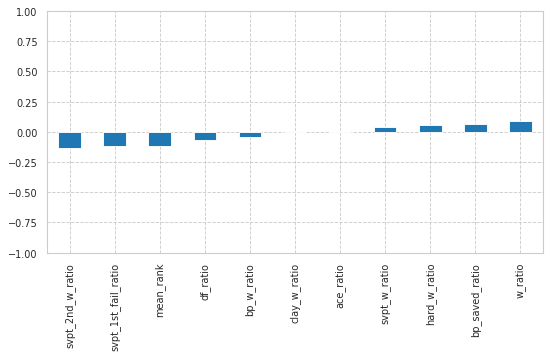

In [99]:
clustered_players[clustered_players.cluster.isin([1, 2, 4, 5])].corr()['cluster'].sort_values().drop('cluster').plot(
    kind='bar',
    ylim=(-1, 1),
    figsize=(8, 4)
)
pass

They appear to be outliers in terms of various features as we can see from the following scatter matrix

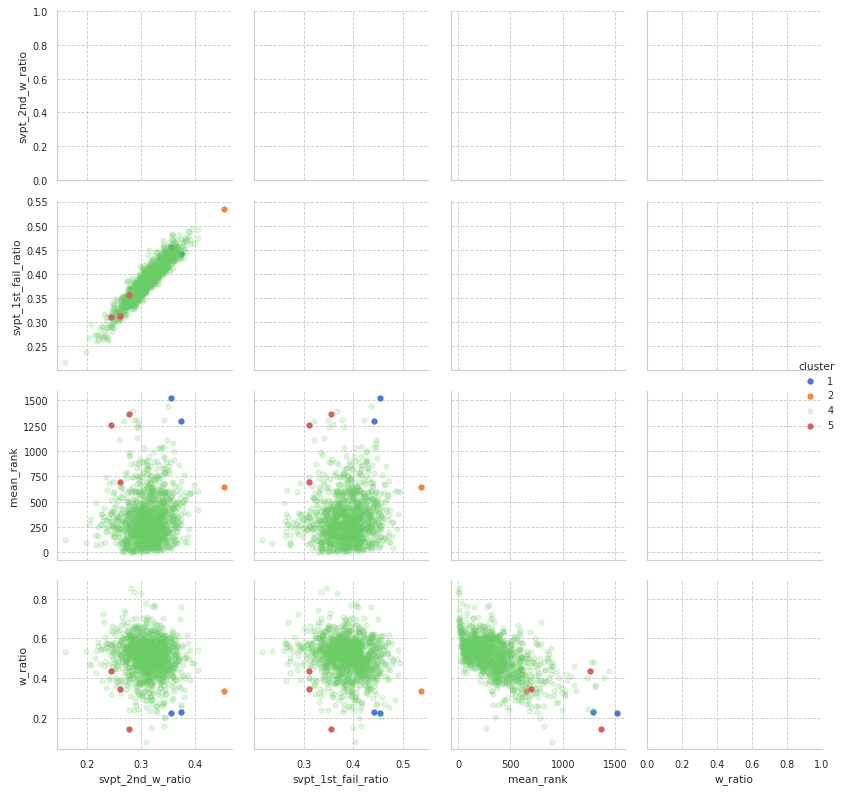

In [100]:
feature_subset = ['svpt_2nd_w_ratio', 'svpt_1st_fail_ratio', 'mean_rank', 'w_ratio']

tmp = clustered_players.loc[clustered_players.cluster.isin([1, 2, 4, 5]), feature_subset + ['cluster']].copy().reset_index()
tmp.cluster = tmp.cluster.astype(int)
tmp[feature_subset] = tmp[feature_subset].astype(float)
g = sns.PairGrid(data=tmp, hue="cluster", palette='muted', hue_kws={"alpha": [1, 1, 0.2, 1]})
g = g.map_lower(plt.scatter)
g = g.add_legend()
plt.tight_layout()
plt.show()
pass

---
## Single (min) method

Last but not least, let's see the dendrogram of the last method, i.e. the Single method

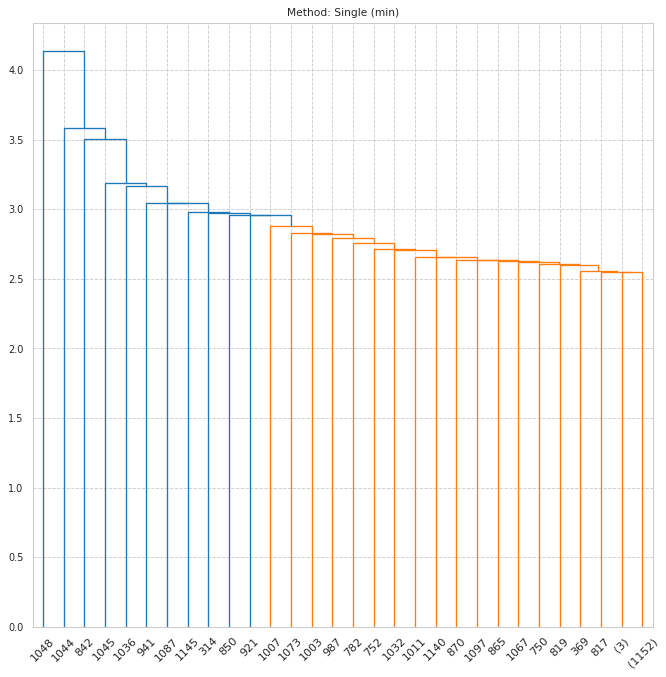

In [112]:
plt.figure(figsize=(10, 10))
plt.title('Method: Single (min)')
linkage_min = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(linkage_min, truncate_mode='lastp')

The Single method seems to indicate progressively more and more outliers in a similar way the Average method did. In fact, if we expand the right-most cluster of the dendrogram, we could see that it is also composed by agglomerating big clusters with small clusters (even made by just a single player!)

To prove that, let's see a scatter plot of these 29 clusters shown in the upper dendrogram compared to the bigger 30th cluster:

In [125]:
clustering_labels_min = fcluster(linkage_min, 30, criterion='maxclust')

clustered_players = clustering_data['original'].copy()
clustered_players['cluster'] = clustering_labels_min

In [126]:
outliers_clusters = clustered_players.groupby('cluster').size().loc[clustered_players.groupby('cluster').size() < 4].index
clustered_players.loc[clustered_players.cluster.isin(outliers_clusters), 'cluster'] = 31

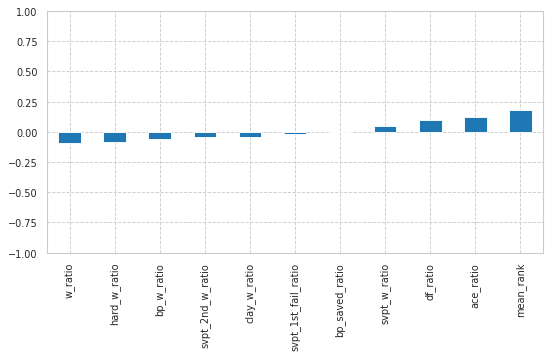

In [131]:
clustered_players.corr()['cluster'].sort_values().drop('cluster').plot(
    kind='bar',
    ylim=(-1, 1),
    figsize=(8, 4)
)
pass

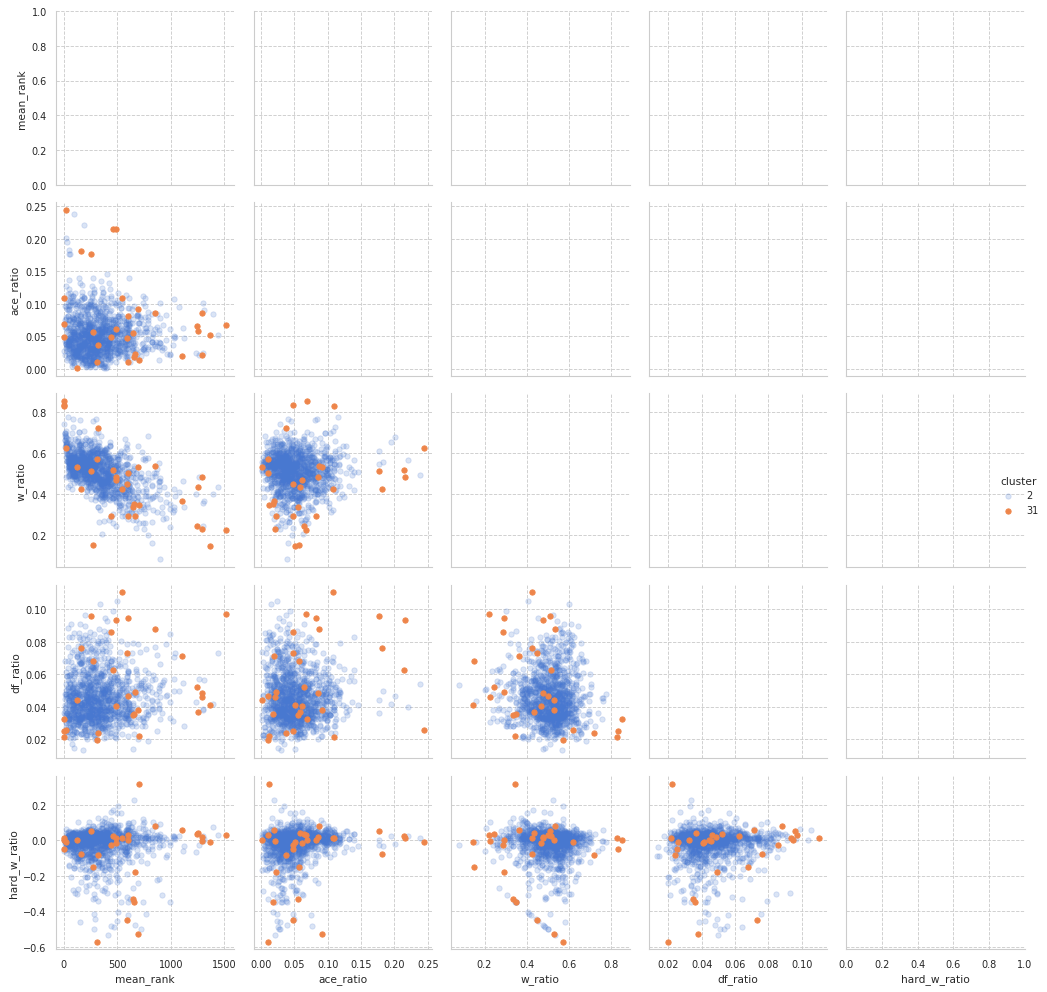

In [133]:
feature_subset = ['mean_rank', 'ace_ratio', 'w_ratio', 'df_ratio', 'hard_w_ratio']

tmp = clustered_players[feature_subset + ['cluster']].copy().reset_index()
tmp.cluster = tmp.cluster.astype(int)
tmp[feature_subset] = tmp[feature_subset].astype(float)
g = sns.PairGrid(data=tmp, hue="cluster", palette='muted', hue_kws={"alpha": [0.2, 1]})
g = g.map_lower(plt.scatter)
g = g.add_legend()
plt.tight_layout()
plt.show()
pass